# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']


record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag)
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)


🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## Quantization of the coefficients

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒


ValueError: operands could not be broadcast together with shapes (1,64) (529,256) 

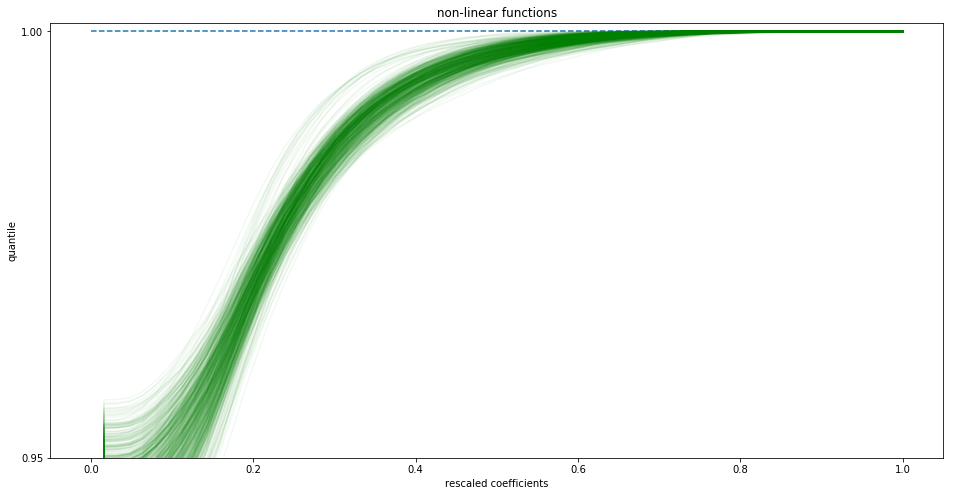

In [4]:
coding_gain = {}
for homeo_method in homeo_methods:
    print(42*'🐶')
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    print(42*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico_ = dico[homeo_method]
    print(42*'🐒')
    from shl_scripts.shl_encode import mp

    sparse_code = mp(data[indx, :], dico_.dictionary, l0_sparseness=shl.l0_sparseness, 
                     #                           P_cum=dico_.P_cum, gain=None
                                              P_cum=None, gain=np.ones(shl.n_dictionary),

                        )

    #from shl_scripts.shl_learn import get_P_cum
    #P_cum = get_P_cum(sparse_code, C=shl.C, nb_quant=shl.nb_quant)
    #P_cum.shape

    P_cum = dico_.P_cum
    #P_cum.shape

    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(P_cum, verbose=False);
    #P_cum.mean(axis=0).shape

    P_cum_mean = P_cum.mean(axis=0)[np.newaxis, :] * np.ones((shl.n_dictionary, shl.nb_quant))
    fig, ax = plot_P_cum(P_cum_mean, fig=fig, ax=ax, c='b', verbose=False)
    plt.show()

    from shl_scripts.shl_encode import quantile, rescaling
    #sparse_code = mp(data, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum)
    stick = np.arange(shl.n_dictionary)*shl.nb_quant
    q = quantile(P_cum, rescaling(sparse_code, C=shl.C), stick, do_fast=True)

    from shl_scripts.shl_encode import inv_quantile, inv_rescaling
    q_sparse_code = inv_rescaling(inv_quantile(P_cum, q), C=shl.C)
    print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(sparse_code.ravel(), q_sparse_code.ravel(), c='b', alpha=.2);


    #q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=shl.C)
    q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=shl.C)
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code)))
    print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

    #fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(sparse_code.ravel(), q_sparse_code.ravel(), c='r', alpha=.2);
    plt.show()

    #patches = q_sparse_code @ dico_.dictionary
    #error = data[indx, :] - patches
    from shl_scripts.shl_tools import print_stats
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, q_sparse_code, verbose=False, display=False)

#     from shl_scripts.shl_tools import print_stats
#     fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
#     print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
#     print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
#     #SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
#     SD = np.linalg.norm(data[indx, :])/record_num_batches
#     print('median energy of data = ', np.median(SD))
#     print('average energy of data = ', SD.mean(), '+/-', SD.std())
#     #print('total energy of data = ', np.sqrt(np.sum(data**2)))
#     #print('total deviation of data = ', np.sum(np.abs(data)))
#     #SE = np.sqrt(np.mean(error**2, axis=1))
#     SE = np.linalg.norm(error)/record_num_batches

#     print('average energy of residual = ', SE.mean(), '+/-', SE.std())
#     print('median energy of residual = ', np.median(SE))
#     #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
#     #print('total deviation of residual = ', np.sum(np.abs(error)))
#     print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
#     plt.show()
    
    coding_gain[homeo_method] = (SD/SE).mean()

In [ ]:
coding_gain

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts